In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, glob, inspect, sys, pickle, warnings

import xgboost as xgb

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.inspection import permutation_importance

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib_2 as mc
from importlib import reload
reload(mc)

<module 'epri_mc_lib_2' from '/home/marie-anne/code/Oct20_EPRI/Task2/NB/epri_mc_lib_2.py'>

In [2]:
# Define best_model:
def best_model(X_train, y_train, steel, name, model):
    '''run standard scaler and gridsearch CV pipeline on models
    Args:
        -model: initiated model 
        -name : name of model as str
    return list of best estimator and table of results
    '''
    X_train = X_train[X_train.index.str.contains(steel)]
    y_train= y_train[y_train.index.str.contains(steel)]

    
    best_model_stack = list()
    results_cv = dict()
    
    def grid_csv(params):
        
        GSCV = GridSearchCV(model, param_grid = params, scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2', 'neg_root_mean_squared_error'], 
                            refit='neg_root_mean_squared_error', 
                            cv = 5, n_jobs=-1, verbose=True)
        best_clf = GSCV.fit(X_train, y_train)
        best_hyperparams = best_clf.best_params_
        best_score = best_clf.best_score_
        estimator = best_clf.best_estimator_
        print(best_score, best_hyperparams, estimator)
        table = best_clf.cv_results_
        results_cv[name] = table
        return estimator
 
        
    if name == 'Ridge':
        params = {'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'], 
                  'alpha' :  np.arange(0.01, 1, 0.05)} 
        best_model_stack.append(grid_csv(params))
    
    if name == 'Elastic':
        params = {'l1_ratio' : [0, 0.25, 0.5, 1], 
                  'alpha' : np.arange(0.01, 1, 0.05)} 
        best_model_stack.append(grid_csv(params))
    
    if name == 'Tree':
        params = {'max_features' : ['auto', 'sqrt', 'log2'],
                  'criterion' : ['mse', 'friedman_mse', 'mae'],
                  'max_depth' : np.arange(3, 15, 1)}
        best_model_stack.append(grid_csv(params))
        
    if name == 'KNN':
        params = {'n_neighbors' : np.arange(5, 50, 5),
                 'weights' : ['uniform', 'distance'],
                 'algorithm' : ['ball_tree', 'kd_tree', 'brute', 'auto']} 
        best_model_stack.append(grid_csv(params))
    
    if name == 'SVM':
        params = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
                 'C' : [0.2, 0.5, 1]} 
        best_model_stack.append(grid_csv(params))


    if name == 'RF': 
        params = {'n_estimators' : np.arange(100, 1000, 200),
                  'max_features' : ['auto', 'sqrt', 'log2'],
                  'criterion' : ['mse', 'mae'],
                  'max_depth' : np.arange(3, 15, 1),
                 } 
        best_model_stack.append(grid_csv(params))
    
    if name == 'XGB':
        params = {'n_estimators' : np.arange(100, 1000, 200),
                  'gamma': np.arange(0.05, 0.8, 0.5),
                  'reg_lambda':[1e-8,  1e-4],
                  'max_depth' : np.arange(3, 10, 2),
                 } 
        best_model_stack.append(grid_csv(params))

        
    return best_model_stack, results_cv

In [4]:
# Define best_model:
def best_model_bayes(X_train, y_train, steel, name, model):
    warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')
    
    '''run standard scaler and gridsearch CV pipeline on models
    Args:
        -model: initiated model 
        -name : name of model as str
    return list of best estimator and table of results
    '''
    X_train = X_train[X_train.index.str.contains(steel)]
    y_train= y_train[y_train.index.str.contains(steel)]

    
    best_model_stack = list()
    results_cv = dict()
    
    def grid_csv(params):
        
        GSCV = BayesSearchCV(model, search_spaces = params, scoring = 'neg_root_mean_squared_error', 
                            cv = 10, n_jobs=-1, verbose=0)
        best_clf = GSCV.fit(X_train, y_train)
        best_hyperparams = best_clf.best_params_
        best_score = best_clf.best_score_
        estimator = best_clf.best_estimator_
        print(best_score, best_hyperparams, estimator)
        table = best_clf.cv_results_
        results_cv[name] = table
        return estimator
        
    if name == 'Ridge':
        params = {'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'], 
                  'alpha' :  np.arange(0.01, 1, 0.05)} 
        best_model_stack.append(grid_csv(params))
    
    if name == 'Elastic':
        params = {'l1_ratio' : [0, 0.25, 0.5, 1], 
                  'alpha' : np.arange(0.01, 1, 0.02)} 
        best_model_stack.append(grid_csv(params))
    
    if name == 'Tree':
        params = {'max_features' : ['auto', 'sqrt', 'log2'],
                  'criterion' : ['mse', 'friedman_mse', 'mae'],
                  'max_depth' : np.arange(3, 15, 1)}
        best_model_stack.append(grid_csv(params))
        
    if name == 'KNN':
        params = {'n_neighbors' : np.arange(5, 100, 5),
                 'weights' : ['uniform', 'distance'],
                 'algorithm' : ['ball_tree', 'kd_tree', 'brute', 'auto']} 
        best_model_stack.append(grid_csv(params))
    
    if name == 'SVM':
        params = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
                 'C' : np.arange(0.01, 1, 0.02)} 
        best_model_stack.append(grid_csv(params))


    if name == 'RF': 
        params = {'n_estimators' : np.arange(100, 1000, 50),
                  'max_features' : ['auto', 'sqrt', 'log2'],
                  'criterion' : ['mse', 'mae'],
                  'max_depth' : np.arange(3, 15, 1),
                  'min_weight_fraction_leaf': np.arange(0, 0.6, 0.2)
                 } 
        best_model_stack.append(grid_csv(params))
    
    if name == 'XGB':
        params = {'n_estimators' : np.arange(100, 1000, 200),
                  'gamma': np.arange(0.05, 0.8, 0.2),
                  'reg_alpha' : [1e-8, 1e-6, 1e-4, 1e-2],
                  'reg_lambda':[1e-8, 1e-6, 1e-4, 1e-2],
                  'max_depth' : np.arange(3, 15, 2),
                  'gamma': np.arange(0.1, 1, 0.2),
                  'subsample': np.arange(0.3, 1, 0.1),
                  'colsample_bytree': np.arange(0.3, 1, 0.1), 
                  'min_child_weight': np.arange(1, 6, 2),
                 } 
        best_model_stack.append(grid_csv(params))

        
    return best_model_stack, results_cv

In [5]:
def train_model(X_train, y_train, X_test, y_test, steel, name, model):
    '''
    predict real values using train models
    Args:
    - steel : id number
    - X_train, X_test : pandas df of features
    - y_train, y_test : pandas df of label, shape 1
    - name : name of the model as str
    - model: model with params
    return y_pred
    '''
    
    X_train = X_train[X_train.index.str.contains(steel)]
    y_train = y_train[y_train.index.str.contains(steel)]
    X_test = X_test[X_test.index.str.contains(steel)]
    y_test = y_test[y_test.index.str.contains(steel)]

    
    if name == 'XGB':
        X_train_df= pd.DataFrame(X_train, columns=feature_names)
        reg = model.fit(X_train_df, y_train)

    else:
        reg = model.fit(X_train, y_train)
        
    y_pred = reg.predict(X_test)
    print(y_test.shape, y_pred.shape)
    
    R2_train = r2_score(y_train, reg.predict(X_train))
    R2_test =  r2_score(y_test, y_pred)
    
    RMSE_training = np.sqrt(mean_squared_error(y_train, reg.predict(X_train)))
    RMSE_testing = np.sqrt(mean_squared_error(y_test, y_pred))
    
    pred_sample = pd.DataFrame({'RMSE_train': RMSE_training, 'RMSE_test': RMSE_testing,
                                    'R2_train':R2_train, 'R2_test':R2_test,
                                     'model':name, 'type': steel
                                    }, index=[0])
    print(pred_sample)
    
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([0, 250], [0, 250])
    plt.xlim([0, 250])
    plt.ylim([0, 250])
    plt.xlabel("Fracture Toughness")
    plt.ylabel("Predicted Fracture Toughness")
    plt.title(steel + '\n' + str(model))
    plt.show()
    
    return reg, pred_sample

In [6]:
def real_pred(steel, X_val_real, y_val_real, model):
    '''
    predict real values using train models
    Args:
    - steel : id number
    - X_val_real : pandas df of features
    - y_val_real : pandas df of label, shape 1
    - model: trained model
    return y_pred
    '''
    X_val_real = X_val_real[X_val_real.index.str.contains(steel)]
    y_val_real = y_val_real[y_val_real.index.str.contains(steel)]
    
    reg_real = model.predict(X_val_real)
    
    print("r2 score for testing: ", r2_score(y_val_real, reg_real))
    print("RMSE score for testing: ", np.sqrt(mean_squared_error(y_val_real, reg_real)))
    
    pred_real = pd.DataFrame({'R2': r2_score(y_val_real, reg_real), 'RMSE': np.sqrt(mean_squared_error(y_val_real, reg_real)),
                                     'model':name, 'type': steel
                                    }, index=[0])

    sns.set(style='white')
    sns.scatterplot(x=y_val_real, y=reg_real)
    plt.plot([0, 250], [0, 250])
    plt.xlim([0, 250])
    plt.ylim([0, 250])
    plt.xlabel("Fracture Toughness")
    plt.ylabel("Predicted Fracture Toughness")
    plt.title(steel + ', ' + name)
    plt.show()
    
    return reg_real, pred_real

In [7]:
def load_data_real(path, scaler):
    '''
    load_data for consistency columns in analyses.
    Args:
    - path : path to csv file
    - scaler :sklearn scaler
    return X, y
    '''

    df = pd.read_csv(path, index_col=0)
    df.index = df.index.str.rstrip('-12345')
    df = df.groupby('ID').mean()
    df['log_MS_Avg'] = np.log(df['MS_Avg'])
    df['log_beta_avg'] = np.log(df['Beta_avg']) 
    df = df[mc.regression_cols].dropna(how='any')
    y_val_real = df['KJIC']
    X_val_real = df.drop(columns=['KJIC'])
    X_val_real = pd.DataFrame(scaler.transform(X_val_real), columns=X_val_real.columns, index=X_val_real.index)
    return  X_val_real, y_val_real

In [8]:
# Define basic features importances:
def get_feature_importance(name, model, feature_names):
    '''return classical feature importances
    Args:
        -name:str
        -model: trained model
    return importance as a df    
    '''
    if name == 'Ridge' or name == 'Elastic':
        importance = model.coef_
        importance_df = pd.DataFrame(importance.T, columns=[name], index=feature_names)
        importance_df.sort_values(name, ascending=True, inplace=True)
       
    if name == 'KNN' or name == 'SVM':
        pass
        
    if name == 'RF' or name == 'Tree': 
        importance = model.feature_importances_
        rel_importance = 100.0 * (importance / importance.sum())
        importance_df = pd.DataFrame(rel_importance.T, columns=[name], index=feature_names)
        importance_df.sort_values(name, ascending=True, inplace=True)
 
    if name == 'XGB':
        importance = model.feature_importances_
        rel_importance = 100.0 * (importance / importance.sum())
        importance_df = pd.DataFrame(rel_importance.T, columns=['XGB'], index=feature_names)
        importance_df.sort_values('XGB', ascending=True, inplace=True)
         
    return importance_df

### Import df and train test split

In [9]:
X_train_ori, X_test_ori, y_train_ori, y_test_ori, scaler = mc.load_data(os.path.join(os.path.dirname(os.getcwd()),'../Data/Merged_data/CopulaGAN_simulated_data_up.csv'),
                                               MinMaxScaler())

In [10]:
# get feature names
feature_names=list(X_train_ori)

### Dummy regressor on all steel

In [11]:
# Evaluate naive

naive = DummyRegressor(strategy='median')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(naive, X_train_ori, y_train_ori, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('Baseline: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Baseline: -31.521 (3.286)


### GridSearch CV

In [12]:
# Create model_dict

model_GSCV = dict()

model_GSCV['Ridge'] = Ridge()
model_GSCV['Elastic'] = ElasticNet()
model_GSCV['Tree'] = DecisionTreeRegressor()
model_GSCV['KNN'] = KNeighborsRegressor()
model_GSCV['SVM'] = SVR()
model_GSCV['RF'] = RandomForestRegressor()
model_GSCV['XGB'] = xgb.XGBRegressor(objective= 'reg:squarederror',
                        eval_metric = 'rmse',
                        learning_rate = 0.01, 
                        nthread=4,
                        seed=42)


#### Bayesian search

In [16]:
all_results_bayes=dict()
for steel in set(X_train_ori.index.str.split('-').str[0]):
    print(steel)
    results_best_model_bayes = list()
    scoring_bayes = dict()
    for name, model in model_GSCV.items():

        scores = best_model_bayes(X_train_ori, y_train_ori, steel, name, model)
        results_best_model_bayes.append(scores[0][0])
        scoring_bayes[name] = pd.DataFrame(scores[1][name])
        
    all_results_bayes[steel] = results_best_model_bayes

    #save params

    with open('Results_CV/Bayes_all_results_CV.p', 'wb') as fp:
        pickle.dump(all_results_bayes, fp, protocol=pickle.HIGHEST_PROTOCOL)


304
-14.495777889632615 OrderedDict([('alpha', 0.060000000000000005), ('solver', 'sag')]) Ridge(alpha=0.060000000000000005, copy_X=True, fit_intercept=True,
      max_iter=None, normalize=False, random_state=None, solver='sag',
      tol=0.001)
-14.469900717030457 OrderedDict([('alpha', 0.03), ('l1_ratio', 1.0)]) ElasticNet(alpha=0.03, copy_X=True, fit_intercept=True, l1_ratio=1.0,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
-15.709835682337038 OrderedDict([('criterion', 'mse'), ('max_depth', 3), ('max_features', 'auto')]) DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                

#### Classic gridsearch

In [ ]:
all_results=dict()
for steel in set(X_train_ori.index.str.split('-').str[0]):
    print(steel)
    results_best_model = list()
    scoring = dict()
    for name, model in model_GSCV.items():

        scores = best_model(X_train_ori, y_train_ori, steel, name, model)
        results_best_model.append(scores[0][0])
        scoring[name] = pd.DataFrame(scores[1][name])

    #save params
    with pd.ExcelWriter(os.path.join(os.getcwd(), 'Results_CV/' + steel + '_result_CV.xlsx')) as writer:
        for df_name, df in scoring.items():
            df.to_excel(writer, sheet_name=df_name) 
    all_results[steel] = results_best_model
    with open('Results_CV/all_results_CV.p', 'wb') as fp:
        pickle.dump(all_results, fp, protocol=pickle.HIGHEST_PROTOCOL)


If you need to add another regressor:

create a new dictionary in the for loop as for example all_results_ridge dict and comment out other regressors in the model_GSCV dict 
then the results and rerun pickle save:


`for k, v in dict_results.items():
    if k in all_results_ridge.keys():
        all_results_ridge[k] += v
    else:
        all_results_ridge[k] = v`


## Regression

In [18]:
with open('Results_CV/Bayes_all_results_CV.p', 'rb') as fp:
    dict_results = pickle.load(fp)
    print(dict_results)

{'304': [Ridge(alpha=0.060000000000000005, copy_X=True, fit_intercept=True,
      max_iter=None, normalize=False, random_state=None, solver='sag',
      tol=0.001), ElasticNet(alpha=0.03, copy_X=True, fit_intercept=True, l1_ratio=1.0,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False), DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best'), KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                    weights='distance'), SVR(C=0.50999999999

(48,) (48,)
   RMSE_train  RMSE_test  R2_train   R2_test  model type
0   14.188695  12.069133  0.791901  0.768108  Ridge  304


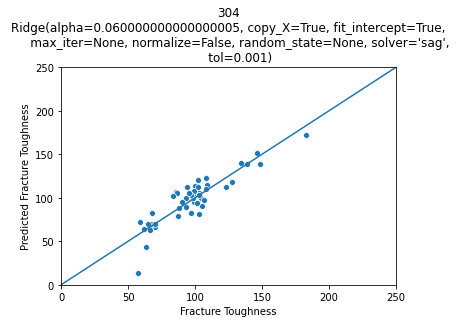

(48,) (48,)
   RMSE_train  RMSE_test  R2_train   R2_test    model type
0   14.163586  12.303411  0.792637  0.759018  Elastic  304


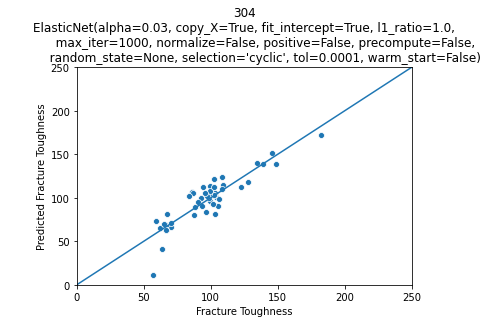

(48,) (48,)
   RMSE_train  RMSE_test  R2_train   R2_test model type
0   12.050059  18.813603  0.849906  0.436522  Tree  304


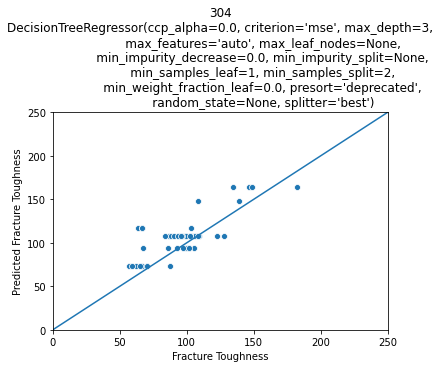

(48,) (48,)
   RMSE_train  RMSE_test  R2_train  R2_test model type
0         0.0  10.491792       1.0  0.82476   KNN  304


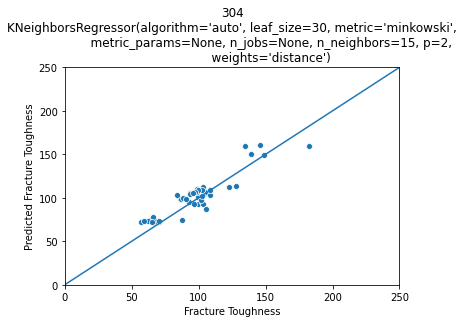

(48,) (48,)
   RMSE_train  RMSE_test  R2_train   R2_test model type
0   14.399071  11.964118  0.785684  0.772126   SVM  304


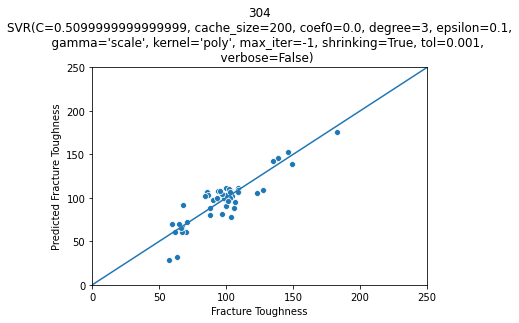

(48,) (48,)
   RMSE_train  RMSE_test  R2_train  R2_test model type
0   13.500321  13.426156  0.811603  0.71303    RF  304


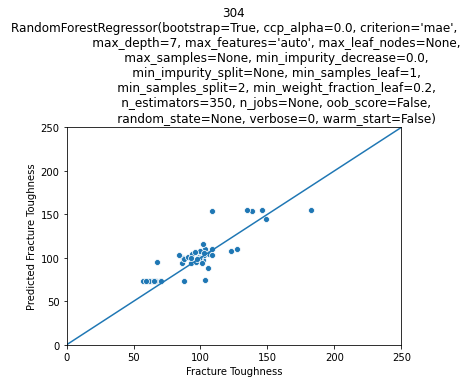

(48,) (48,)
   RMSE_train  RMSE_test  R2_train   R2_test model type
0   10.440021   10.52009  0.887335  0.823814   XGB  304


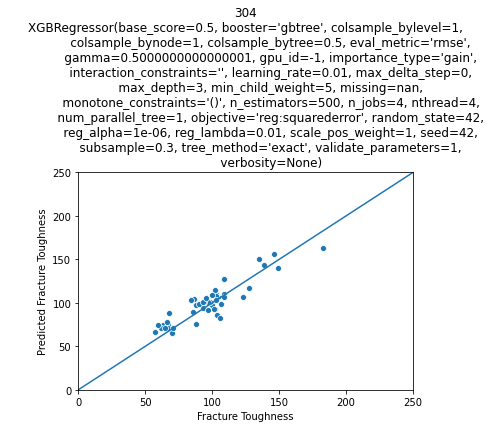

(58,) (58,)
   RMSE_train  RMSE_test  R2_train   R2_test  model type
0   13.585362  12.281298  0.926626  0.913275  Ridge  347


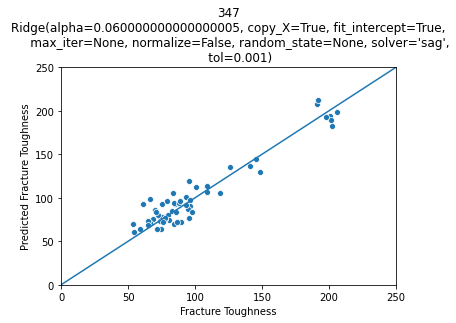

(58,) (58,)
   RMSE_train  RMSE_test  R2_train   R2_test    model type
0   13.532849  12.325263  0.927192  0.912653  Elastic  347


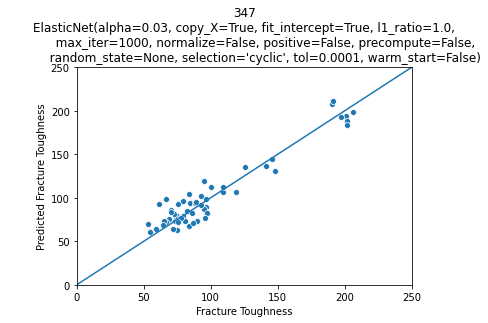

(58,) (58,)
   RMSE_train  RMSE_test  R2_train   R2_test model type
0   10.782516  11.644246  0.953779  0.922039  Tree  347


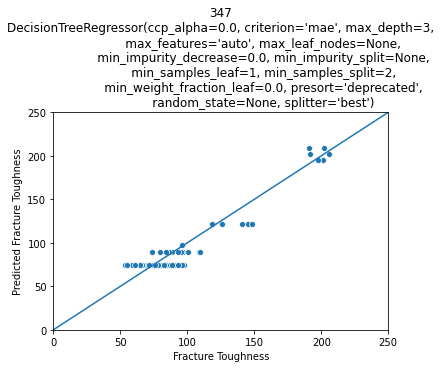

(58,) (58,)
   RMSE_train  RMSE_test  R2_train   R2_test model type
0         0.0  11.189065       1.0  0.928015   KNN  347


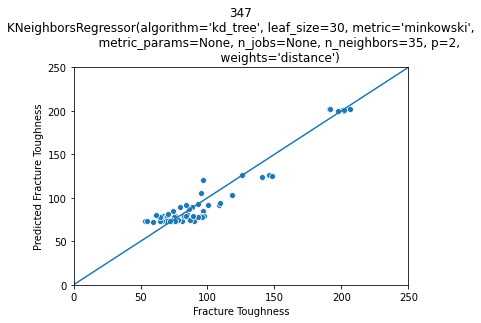

(58,) (58,)
   RMSE_train  RMSE_test  R2_train   R2_test model type
0   13.239553  13.771676  0.930314  0.890949   SVM  347


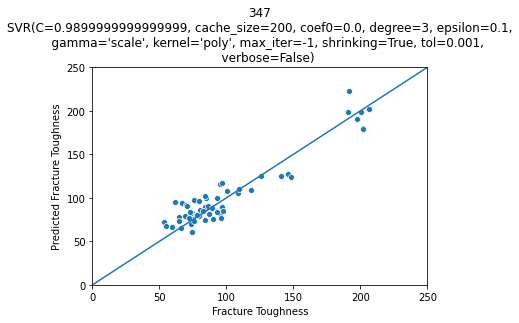

(58,) (58,)
   RMSE_train  RMSE_test  R2_train   R2_test model type
0    4.606395  12.156885  0.991564  0.915023    RF  347


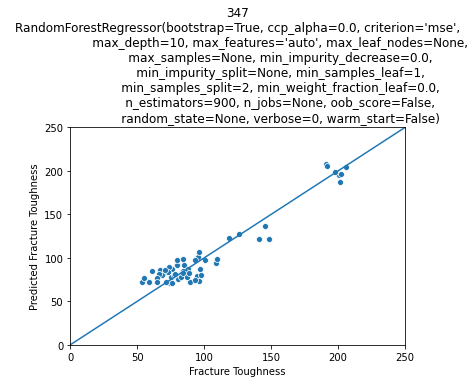

(58,) (58,)
   RMSE_train  RMSE_test  R2_train   R2_test model type
0      0.9863  12.592222  0.999613  0.908828   XGB  347


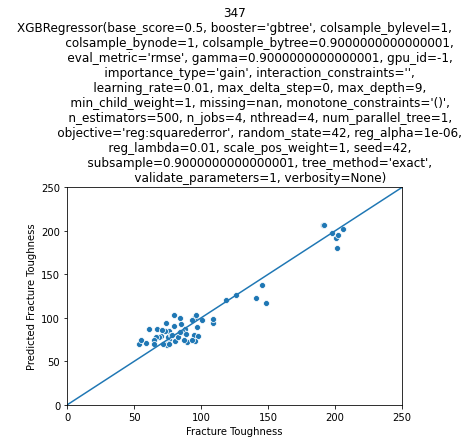

(53,) (53,)
   RMSE_train  RMSE_test  R2_train   R2_test  model type
0   12.201125  14.189924    0.6963  0.673468  Ridge  316


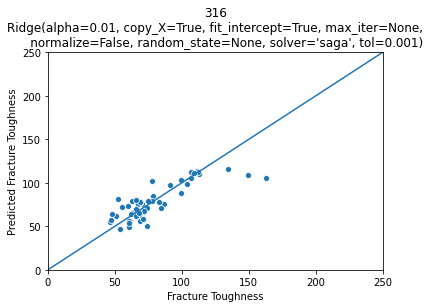

(53,) (53,)
   RMSE_train  RMSE_test  R2_train   R2_test    model type
0   12.202799  14.165475  0.696216  0.674592  Elastic  316


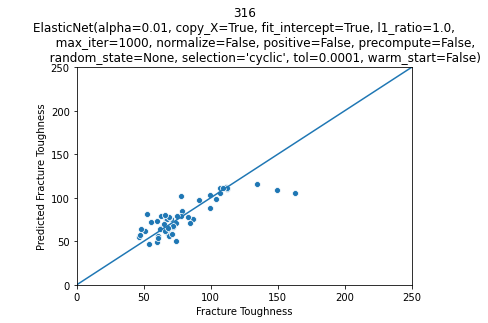

(53,) (53,)
   RMSE_train  RMSE_test  R2_train   R2_test model type
0    7.353667  12.498718   0.88968  0.746664  Tree  316


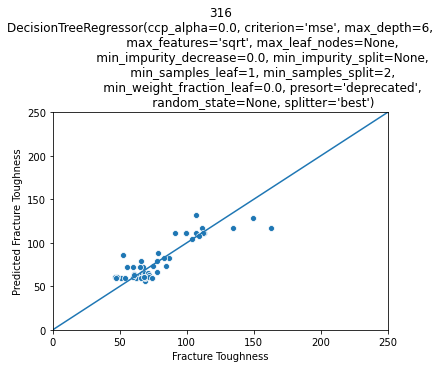

(53,) (53,)
   RMSE_train  RMSE_test  R2_train   R2_test model type
0     0.00001  13.122866       1.0  0.720731   KNN  316


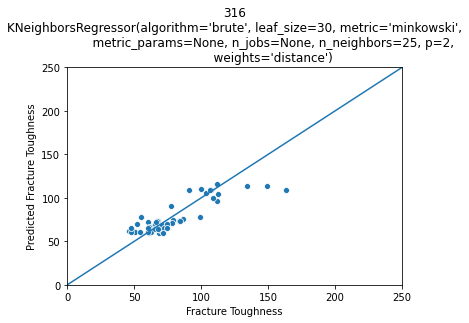

(53,) (53,)
   RMSE_train  RMSE_test  R2_train  R2_test model type
0   13.651311  15.752179  0.619815  0.59761   SVM  316


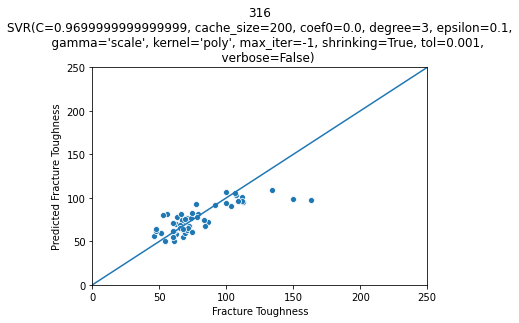

(53,) (53,)
   RMSE_train  RMSE_test  R2_train   R2_test model type
0     4.17595  12.133365  0.964424  0.761258    RF  316


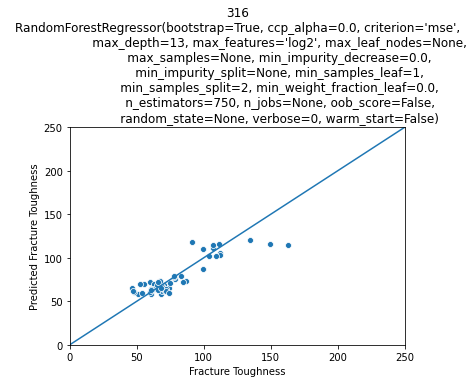

(53,) (53,)
   RMSE_train  RMSE_test  R2_train   R2_test model type
0    2.927896  11.550278  0.982511  0.783653   XGB  316


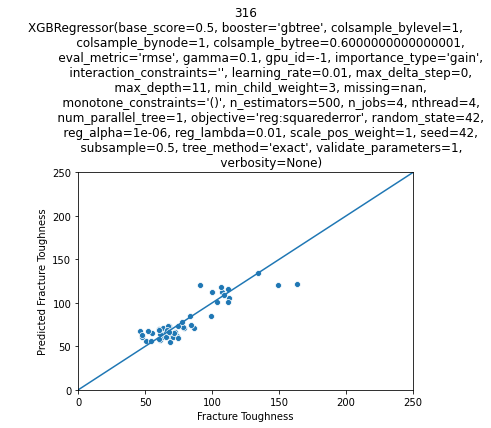

(41,) (41,)
   RMSE_train  RMSE_test  R2_train  R2_test  model  type
0   17.290809   18.38412   0.89729  0.90718  Ridge  A286


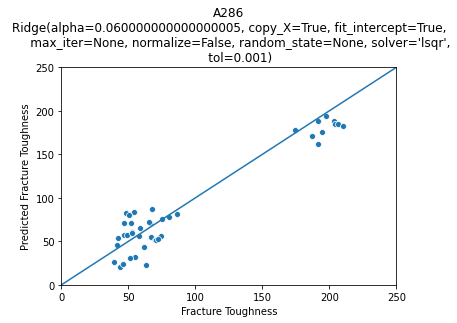

(41,) (41,)
   RMSE_train  RMSE_test  R2_train   R2_test    model  type
0   17.401343  18.489355  0.895973  0.906115  Elastic  A286


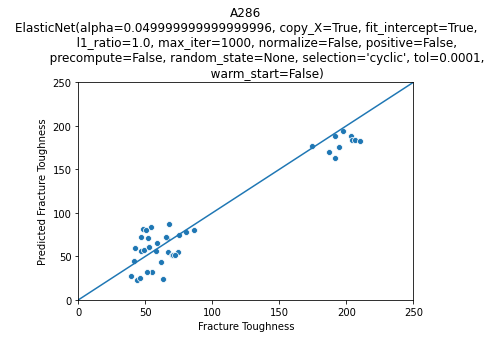

(41,) (41,)
   RMSE_train  RMSE_test  R2_train   R2_test model  type
0     6.62938  12.184477  0.984902  0.959227  Tree  A286


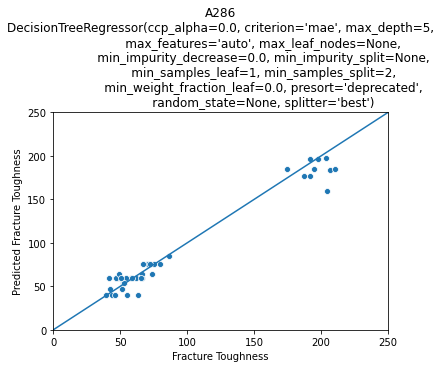

(41,) (41,)
   RMSE_train  RMSE_test  R2_train   R2_test model  type
0         0.0   9.321533       1.0  0.976137   KNN  A286


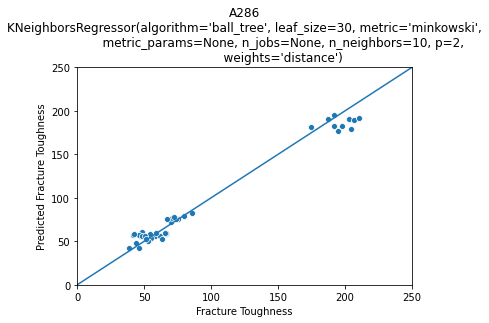

(41,) (41,)
   RMSE_train  RMSE_test  R2_train   R2_test model  type
0   19.937705   22.09423  0.863438  0.865936   SVM  A286


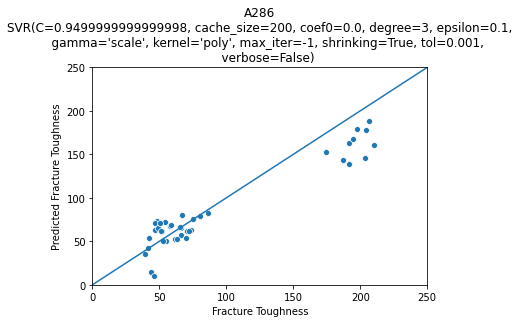

(41,) (41,)
   RMSE_train  RMSE_test  R2_train   R2_test model  type
0    4.082904   9.738749  0.994273  0.973953    RF  A286


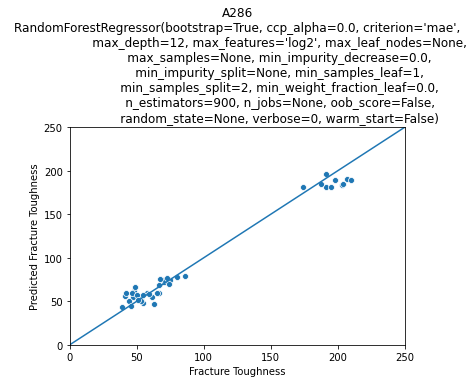

(41,) (41,)
   RMSE_train  RMSE_test  R2_train   R2_test model  type
0     6.16274   9.636734  0.986952  0.974496   XGB  A286


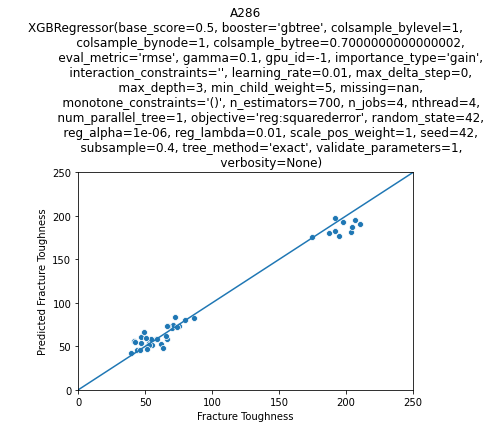

In [19]:
model_names = ['Ridge', 'Elastic', 'Tree', 'KNN', 'SVM', 'RF', 'XGB']
all_regressors=dict()
metrics = pd.DataFrame()
all_metrics = pd.DataFrame()
for steel in set(X_train_ori.index.str.split('-').str[0]):
    
    # Create model_dict
    list_results = dict_results[steel]
    models = dict(zip(model_names, list_results))
    
    # Fit models
    regressors = list()
    for name, model in models.items():
        reg, pred = train_model(X_train_ori, y_train_ori, X_test_ori, y_test_ori, steel, name, model)
        regressors.append(reg)
        metrics = metrics.append(pred, ignore_index=True)
    all_regressors[steel] = regressors
    all_metrics =  all_metrics.append(metrics, ignore_index=True)
    #save params

    with open('Results_CV/all_regressors.p', 'wb') as fp:
        pickle.dump(all_regressors, fp, protocol=pickle.HIGHEST_PROTOCOL)
    

In [32]:
model_cat = pd.api.types.CategoricalDtype(categories=['Ridge', 'Elastic', 'Tree', 'KNN', 'SVM', 'RF', 'XGB'],
                            ordered=True)
RMSE_df.model.astype(model_cat)

0        Ridge
1      Elastic
2         Tree
3          KNN
4          SVM
        ...   
128       Tree
129        KNN
130        SVM
131         RF
132        XGB
Name: model, Length: 126, dtype: category
Categories (7, object): [Ridge < Elastic < Tree < KNN < SVM < RF < XGB]

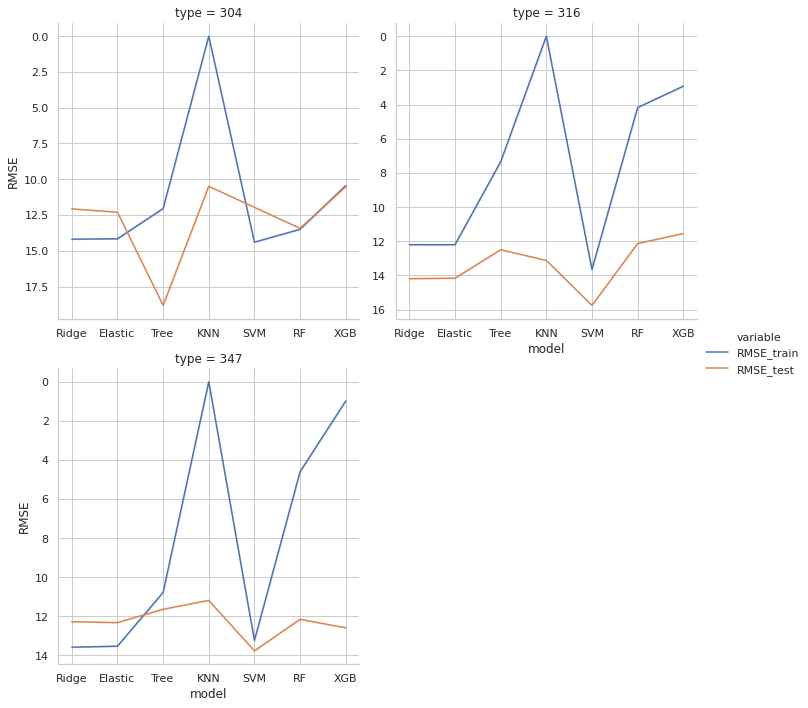

In [33]:
RMSE_df = all_metrics.melt(id_vars=['model', 'type'], 
                           value_name='RMSE', 
                           value_vars=['RMSE_train', 'RMSE_test'])
RMSE_df.model = RMSE_df.model.astype(model_cat)
RMSE_df = RMSE_df[RMSE_df.type != 'A286']

sns.set(style='whitegrid')
g = sns.relplot(x='model', y='RMSE', kind='line', data = RMSE_df, hue = 'variable',
           col='type', col_wrap=2,
           facet_kws={'sharex': False, 'sharey': False})
for yaxes in g.fig.get_axes():
    yaxes.invert_yaxis()

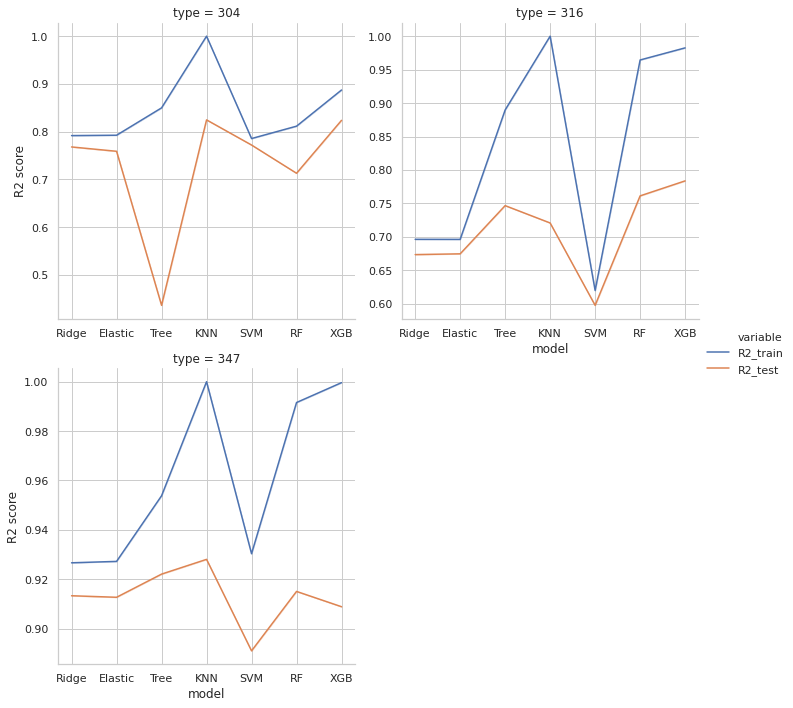

In [35]:
RMSE_df = all_metrics.melt(id_vars=['model', 'type'], 
                           value_name='R2 score', 
                           value_vars=['R2_train', 'R2_test'])
RMSE_df.model = RMSE_df.model.astype(model_cat)

RMSE_df = RMSE_df[RMSE_df.type != 'A286']

sns.set(style='whitegrid')
g = sns.relplot(x='model', y='R2 score', kind='line', data = RMSE_df, hue = 'variable',
           col='type', col_wrap=2,
           facet_kws={'sharex': False, 'sharey': False})


# Test on real data

In [36]:
with open('Results_CV/all_regressors.p', 'rb') as fp:
    dict_regressors = pickle.load(fp)
    print(dict_regressors)

{'304': [Ridge(alpha=0.060000000000000005, copy_X=True, fit_intercept=True,
      max_iter=None, normalize=False, random_state=None, solver='sag',
      tol=0.001), ElasticNet(alpha=0.03, copy_X=True, fit_intercept=True, l1_ratio=1.0,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False), DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best'), KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                    weights='distance'), SVR(C=0.50999999999

In [37]:
X_val_real, y_val_real = load_data_real(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/MERGE_FT_TEP_UT_on_ID.csv'),
               scaler) # using the scaler from the load_data

r2 score for testing:  0.9649338362748368
RMSE score for testing:  5.564815967559719


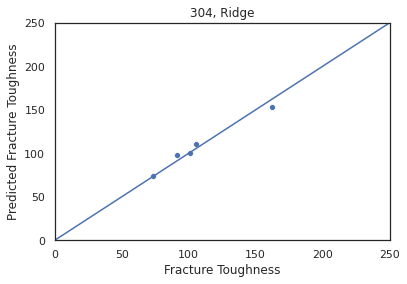

r2 score for testing:  0.9650924002433721
RMSE score for testing:  5.552220077836647


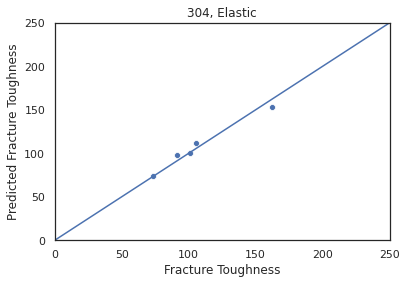

r2 score for testing:  0.9847104120221348
RMSE score for testing:  3.67455345419601


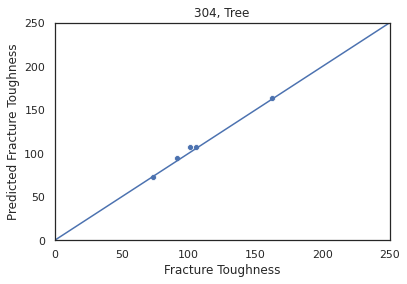

r2 score for testing:  0.9782861551588821
RMSE score for testing:  4.379000990972239


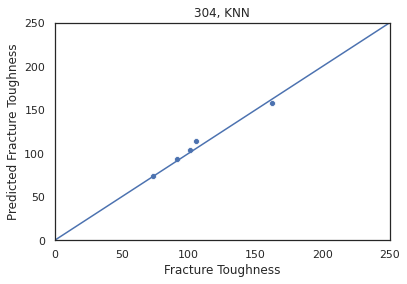

r2 score for testing:  0.9677970958924909
RMSE score for testing:  5.3327865108069314


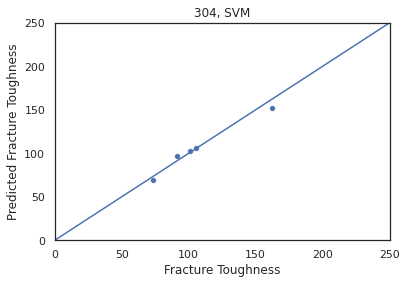

r2 score for testing:  0.9831843269880216
RMSE score for testing:  3.8535749059191224


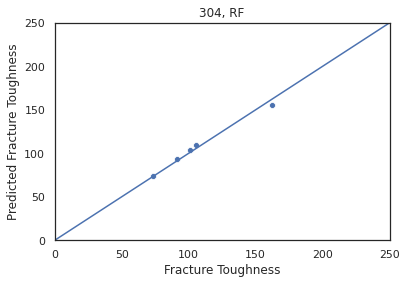

r2 score for testing:  0.9776630579207791
RMSE score for testing:  4.441386185524862


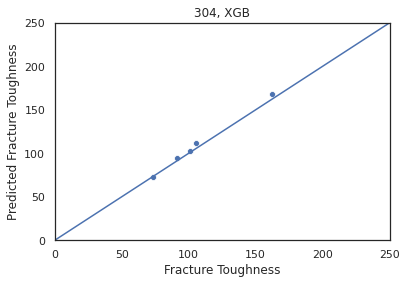

r2 score for testing:  0.9580492892380075
RMSE score for testing:  9.486902939347274


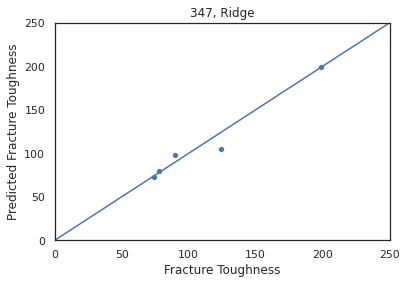

r2 score for testing:  0.960256119756874
RMSE score for testing:  9.234001237267014


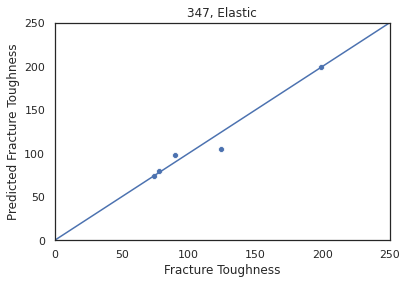

r2 score for testing:  0.9973421123250849
RMSE score for testing:  2.387938333249284


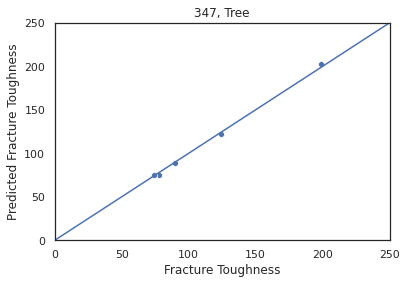

r2 score for testing:  0.9906764058806344
RMSE score for testing:  4.472460104881235


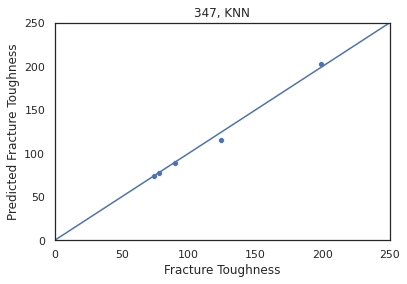

r2 score for testing:  0.9808555922586621
RMSE score for testing:  6.408785901427736


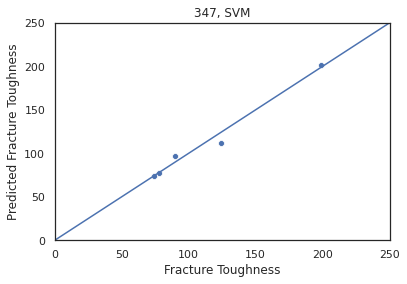

r2 score for testing:  0.9939765315704707
RMSE score for testing:  3.5948279927088502


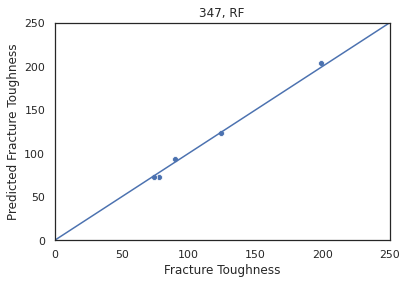

r2 score for testing:  0.9934950588393485
RMSE score for testing:  3.7357386180191385


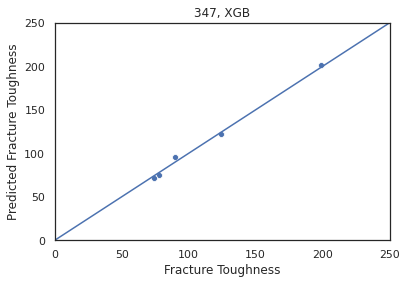

r2 score for testing:  0.848772311333404
RMSE score for testing:  7.091016461956626


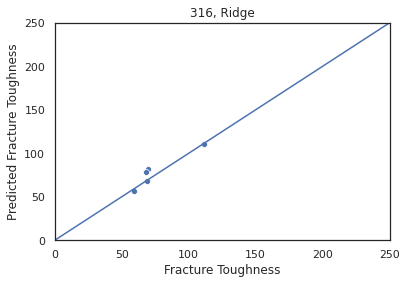

r2 score for testing:  0.8482271606380902
RMSE score for testing:  7.1037859325378125


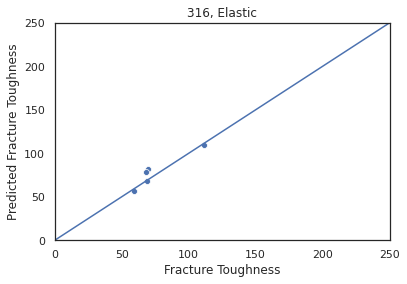

r2 score for testing:  0.8077818325631723
RMSE score for testing:  7.994476911118768


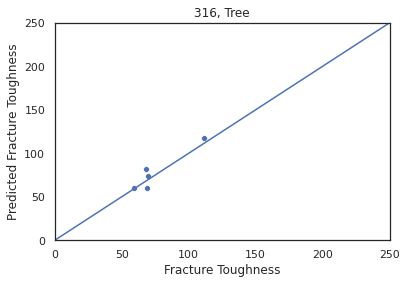

r2 score for testing:  0.9873693012172557
RMSE score for testing:  2.0493046496762823


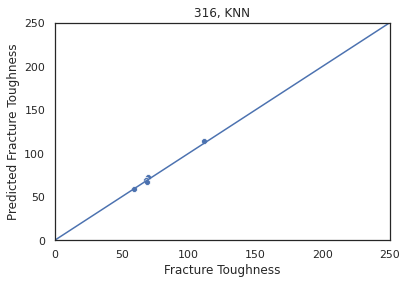

r2 score for testing:  0.7111451405982572
RMSE score for testing:  9.800148924952257


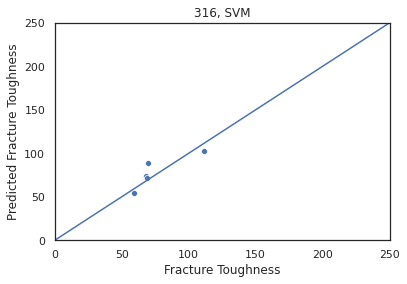

r2 score for testing:  0.9112502827270433
RMSE score for testing:  5.432207182587191


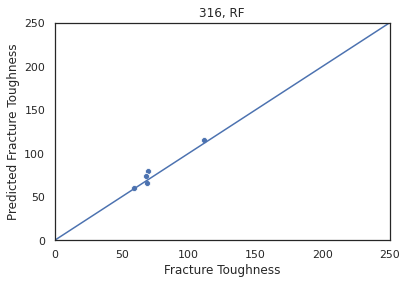

r2 score for testing:  0.930367449567213
RMSE score for testing:  4.811704934880246


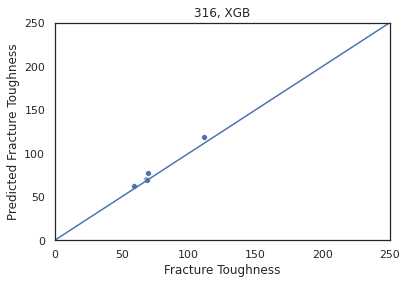

r2 score for testing:  0.9953627539334895
RMSE score for testing:  3.8915100764886184


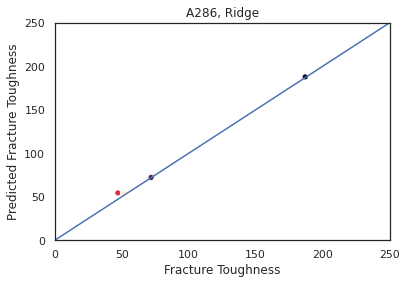

r2 score for testing:  0.9945494702946513
RMSE score for testing:  4.218979780423169


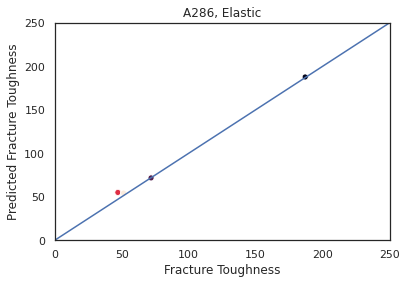

r2 score for testing:  0.9838465367767978
RMSE score for testing:  7.263081411985113


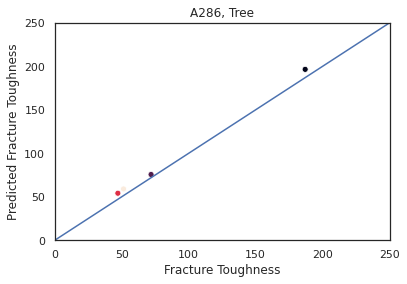

r2 score for testing:  0.9879949415893325
RMSE score for testing:  6.26138238760557


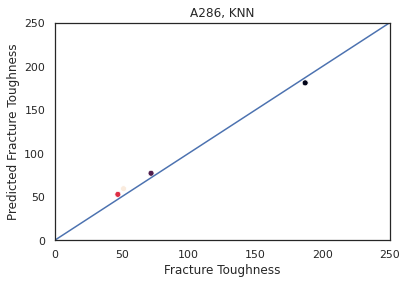

r2 score for testing:  0.9951711319376488
RMSE score for testing:  3.971099403192939


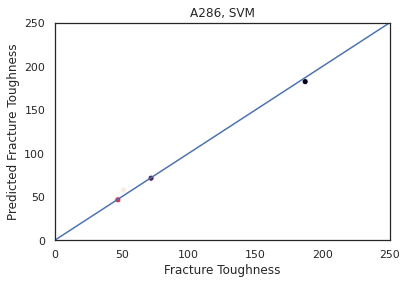

r2 score for testing:  0.9917962862069614
RMSE score for testing:  5.1759889300806545


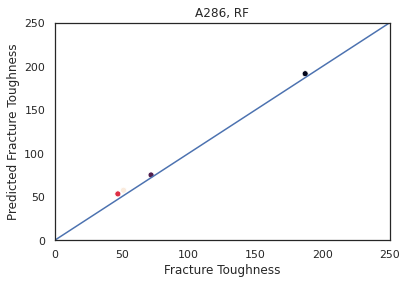

r2 score for testing:  0.9929603483149582
RMSE score for testing:  4.794724677510368


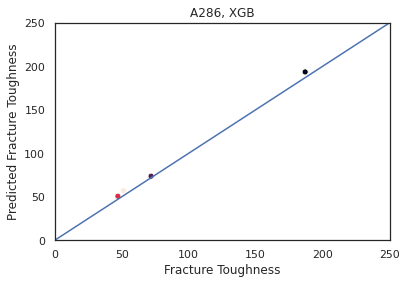

In [38]:
real_regressors = dict()
real_metrics = pd.DataFrame()
all_real_metrics = pd.DataFrame()
for steel in set(X_train_ori.index.str.split('-').str[0]):
    
    reg_real_list = list()
    
    # Create model_dict
    list_reg = dict_regressors[steel]
    models = dict(zip(model_names, list_reg))
    for name, model in models.items():
        reg_real, pred_real = real_pred(steel, X_val_real, y_val_real, model)
        reg_real_list.append(reg_real)
        real_metrics = real_metrics.append(pred_real, ignore_index=True)

    real_regressors[steel] = reg_real_list
    all_real_metrics =  all_real_metrics.append(real_metrics, ignore_index=True)
    #save params

    with open('Results_CV/all_regressors_real.p', 'wb') as fp:
        pickle.dump(all_regressors, fp, protocol=pickle.HIGHEST_PROTOCOL)

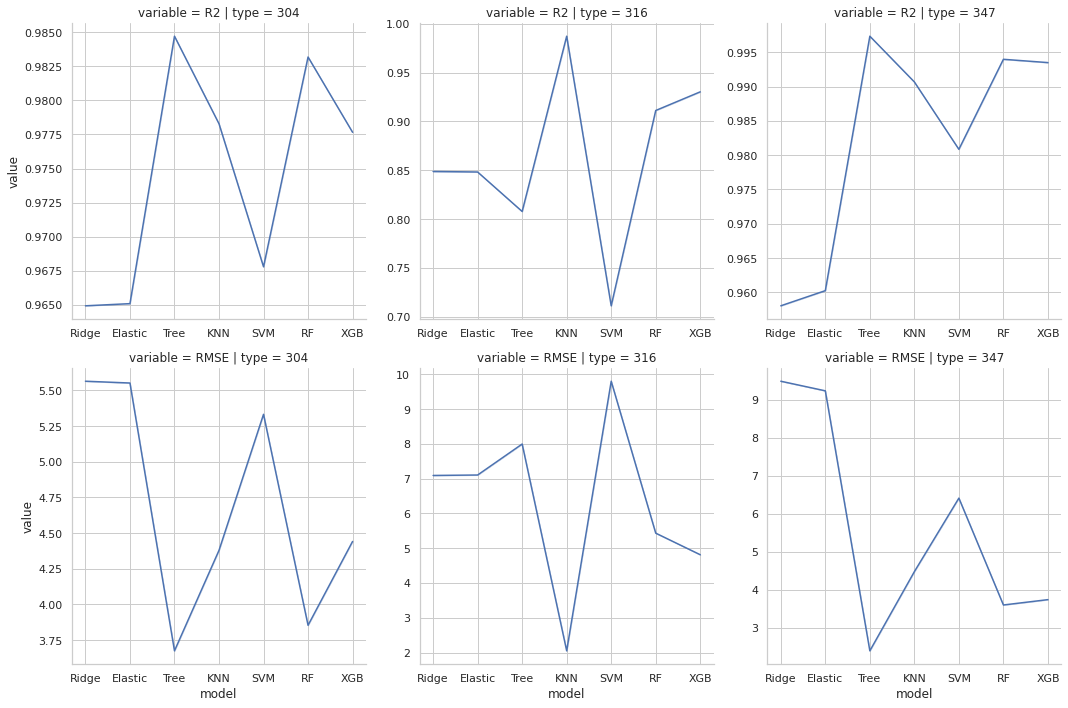

In [41]:
RMSE_real_df = all_real_metrics.melt(id_vars=['model', 'type'], 
                           #value_name=['R2 score', 'RMSE'], 
                           value_vars=['R2', 'RMSE'])
RMSE_real_df.model = RMSE_real_df.model.astype(model_cat)

RMSE_real_df = RMSE_real_df[RMSE_real_df.type != 'A286']

sns.set(style='whitegrid')
g = sns.relplot(x='model', y='value', kind='line', data = RMSE_real_df, row = 'variable',
           col='type', facet_kws={'sharex': False, 'sharey': False})

# Feature importance

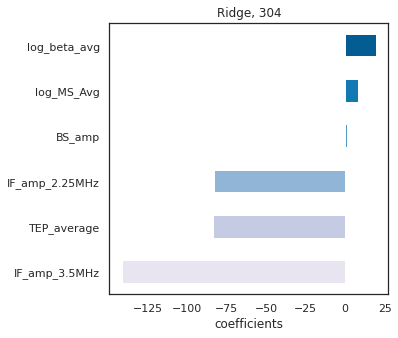

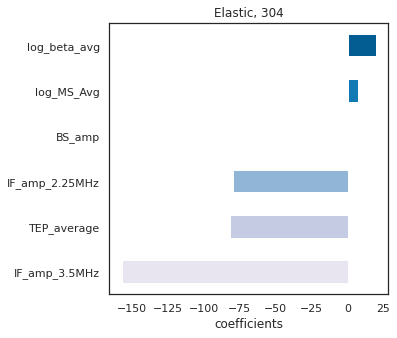

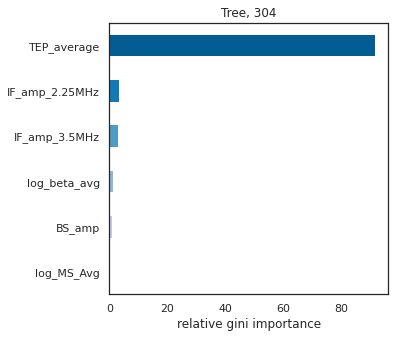

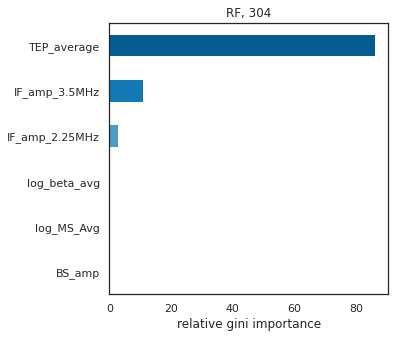

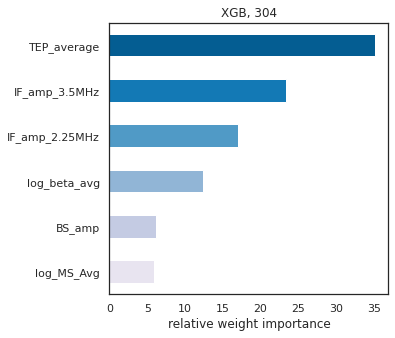

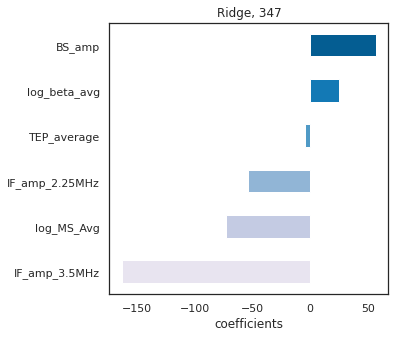

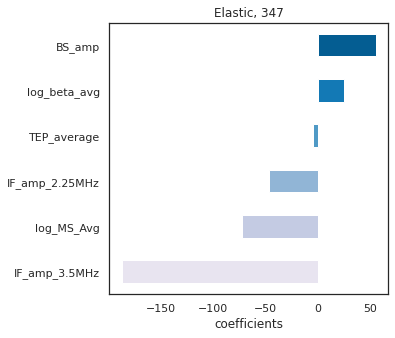

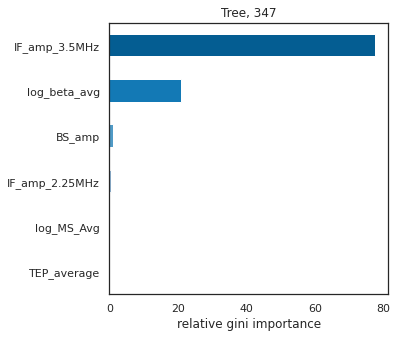

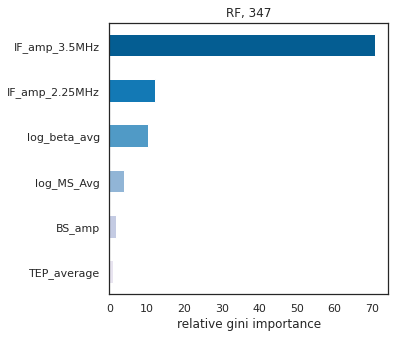

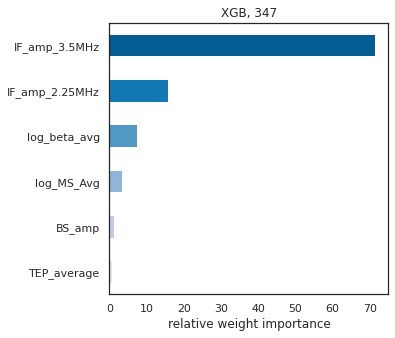

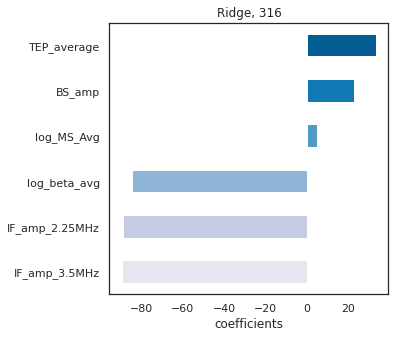

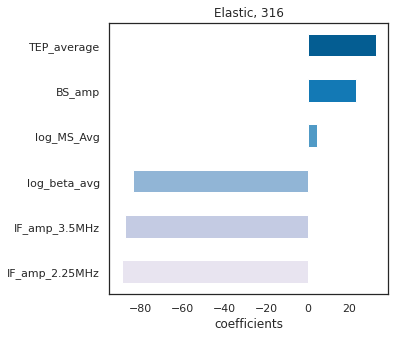

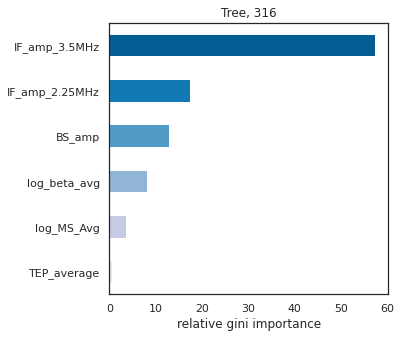

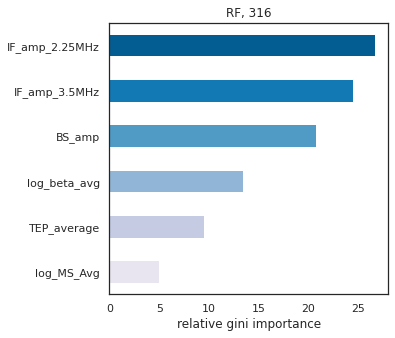

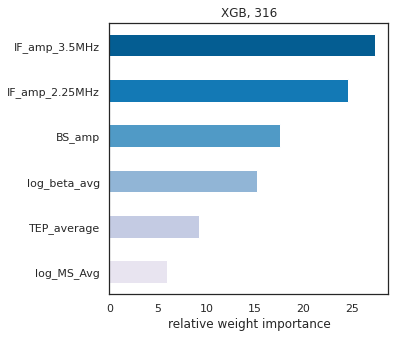

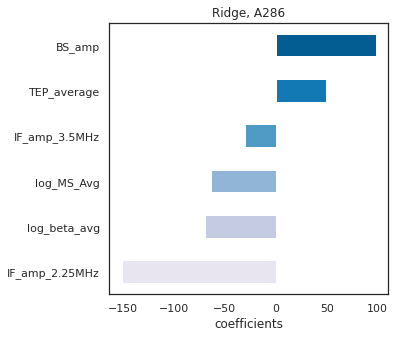

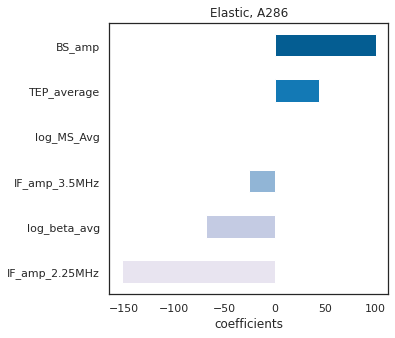

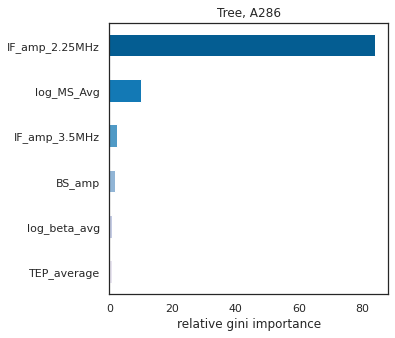

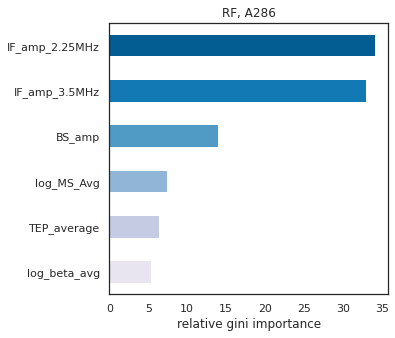

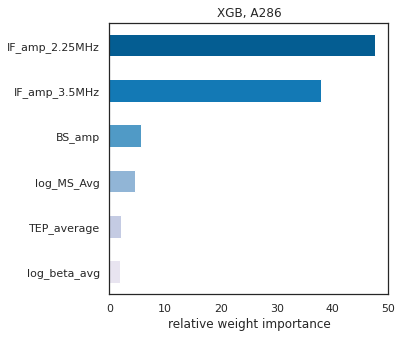

In [42]:
model_names = ['Ridge', 'Elastic', 'Tree', 'KNN', 'SVM', 'RF', 'XGB']
sns.set(style='white')
for steel in set(X_train_ori.index.str.split('-').str[0]):
        
    # Create model_dict
    list_results = dict_results[steel]
    models = dict(zip(model_names, list_results))

    for name, model in models.items():
        if name == 'KNN' or name == 'SVM':
            continue
        classic = get_feature_importance(name, model, feature_names)
        classic.plot.barh(figsize=(5,5), color=[sns.color_palette(palette='PuBu', n_colors=len(feature_names))], 
                          legend=False, title=name + ', ' + steel)
       
        if name=='Ridge' or  name=='Elastic' or name=='SVM':
            plt.xlabel('coefficients')

        if name=='RF' or name == 'Tree':
            plt.xlabel('relative gini importance') 
            
        if name=='XGB':
            plt.xlabel('relative weight importance')

